In [1]:
# imports

import os
import re
import math
import random
from datetime import datetime
import numpy as np
from typing import Optional
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
from huggingface_hub import login
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset, DatasetDict
from concurrent.futures import ProcessPoolExecutor
from transformers import AutoTokenizer
from items import Item, read_dataset
import pickle

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# constants

MAX_DESCRIPTION_AND_FEATURES_CHARS = 120
MIN_TOKENS = 100
MAX_TOKENS = 175
CUTOFF_CHARS = MAX_TOKENS * 6

In [62]:
# initialize

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-4o-mini"
CLAUDE_MODEL = "claude-3-5-sonnet-20240620"
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)
PHI3 = "microsoft/Phi-3-medium-4k-instruct"
GEMMA = "google/gemma-2-9b-it"

Token is valid (permission: write).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/ed/.cache/huggingface/token
Login successful


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
%matplotlib inline

In [6]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"

In [7]:
dataset_names = [
    "Clothing_Shoes_and_Jewelry",
    "Beauty_and_Personal_Care",
    "Health_and_Household",
    "Home_and_Kitchen",
    "Sports_and_Outdoors",
    "Electronics",
    "Industrial_and_Scientific",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Patio_Lawn_and_Garden",
    "Automotive",
    "Cell_Phones_and_Accessories",
    "Pet_Supplies",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [8]:
start = datetime.now()
items = []
with ProcessPoolExecutor(max_workers=7) as pool:
    for results in pool.map(read_dataset, dataset_names):
        items.extend(results)
finish = datetime.now()
print(f"Completed in {(finish-start).total_seconds()/60:.1f} mins")

Loading dataset Clothing_Shoes_and_Jewelry
Loading dataset Sports_and_Outdoors
Loading dataset Beauty_and_Personal_Care
Loading dataset Health_and_Household
Loading dataset Industrial_and_Scientific
Loading dataset Electronics
Loading dataset Home_and_Kitchen
Completed loading Industrial_and_Scientific with 204,010 datapoints
Loading dataset Office_Products
Completed loading Health_and_Household with 307,032 datapoints
Loading dataset Tools_and_Home_Improvement
Completed loading Beauty_and_Personal_Care with 335,450 datapoints
Loading dataset Patio_Lawn_and_Garden
Completed loading Office_Products with 268,830 datapoints
Loading dataset Automotive
Completed loading Sports_and_Outdoors with 453,642 datapoints
Loading dataset Cell_Phones_and_Accessories
Completed loading Electronics with 499,963 datapoints
Loading dataset Pet_Supplies
Completed loading Patio_Lawn_and_Garden with 342,274 datapoints
Loading dataset Toys_and_Games
Completed loading Pet_Supplies with 153,043 datapoints
Loadi

In [9]:
len(items)

7459189

In [16]:
items = [item for item in items if item.token_count<=180]

In [17]:
len(items)

7459188

In [18]:
with open('items.pkl', 'wb') as file:
    pickle.dump(items, file)

In [7]:
with open('items.pkl', 'rb') as file:
    items = pickle.load(file)

In [11]:
# Let's investigate:

print(f"There are {len(items):,} items with prices\n")
print(items[0].text)
print('___')
print(items[0].messages())

There are 7,459,188 items with prices

BALEAF Women's Long Sleeve Zip Beach Coverup UPF 50+ Sun Protection Hooded Cover Up Shirt Dress with Pockets Department womens, Available April 3, 2022 90% Polyester, 10% Spandex Zipper closure Machine Wash Long sleeve sun protection coverups--UPF 50+ blocks the sun from burning Zipped v-neckline--fashionable V neck and smooth 1/4 zipper allows to staying place as you like Two drop-in side pockets--hold your phone or keys well，no worries of falling out Hoodie with non-slip drawcord--Enhancing hooded design is convenient to wrap your face and enough space to put your head and
___
[{'role': 'system', 'content': 'You estimate prices to the nearest dollar'}, {'role': 'user', 'content': "How much is this?\nBALEAF Women's Long Sleeve Zip Beach Coverup UPF 50+ Sun Protection Hooded Cover Up Shirt Dress with Pockets Department womens, Available April 3, 2022 90% Polyester, 10% Spandex Zipper closure Machine Wash Long sleeve sun protection coverups--UPF 50

Average length is 819.6 and highest length is 1,340



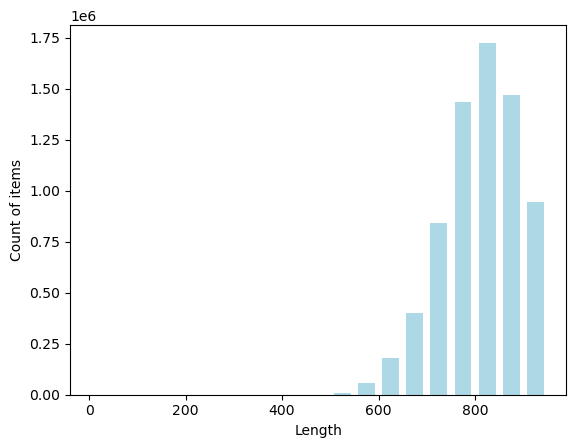

In [12]:
# Plot the distribution of character count

lengths = [len(item.prompt) for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Length')
ax.set_ylabel('Count of items');
_ = ax.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 1000, 50))

print(f"Average length is {sum(lengths)/len(lengths):,.1f} and highest length is {max(lengths):,}\n")

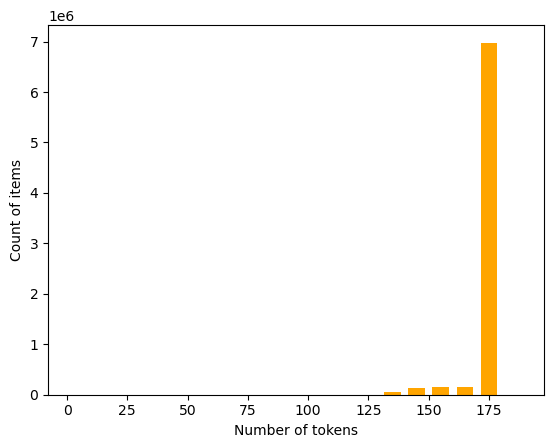

In [13]:
# Plot the distribution of tokens

token_counts = [item.token_count for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of items');
_ = ax.hist(token_counts, rwidth=0.7, color="orange", bins=range(0, 200, 10))

In [14]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [15]:
report(items[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You estimate prices to the nearest dollar<|eot_id|><|start_header_id|>user<|end_header_id|>

How much is this?
BALEAF Women's Long Sleeve Zip Beach Coverup UPF 50+ Sun Protection Hooded Cover Up Shirt Dress with Pockets Department womens, Available April 3, 2022 90% Polyester, 10% Spandex Zipper closure Machine Wash Long sleeve sun protection coverups--UPF 50+ blocks the sun from burning Zipped v-neckline--fashionable V neck and smooth 1/4 zipper allows to staying place as you like Two drop-in side pockets--hold your phone or keys well，no worries of falling out Hoodie with non-slip drawcord--Enhancing hooded design is convenient to wrap your face and enough space to put your head and<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Price is $32.00<|eot_id|>
[78191, 128007, 271, 7117, 374, 400, 843, 13, 410, 128009]
['assistant', '<|end_header_id|>', '\n\n', 'Price', ' is', ' $', '32', '.', '00', '<|eot_id|>']


Average price is $49.77 and highest price is $999.49



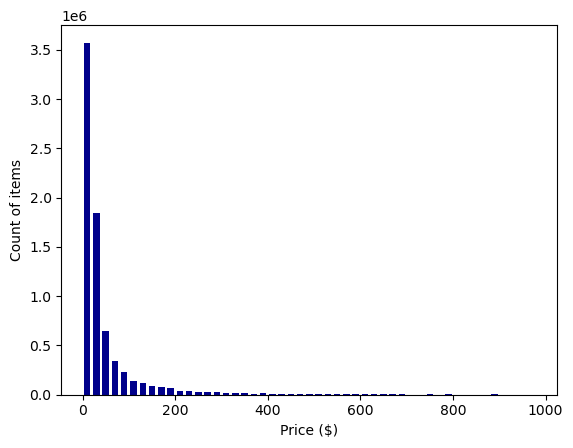

In [16]:
# Plot the distribution of prices

prices = [float(item.price) for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Count of items');
_ = ax.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 20))

print(f"Average price is ${sum(prices)/len(prices):.2f} and highest price is ${max(prices):,.2f}\n")

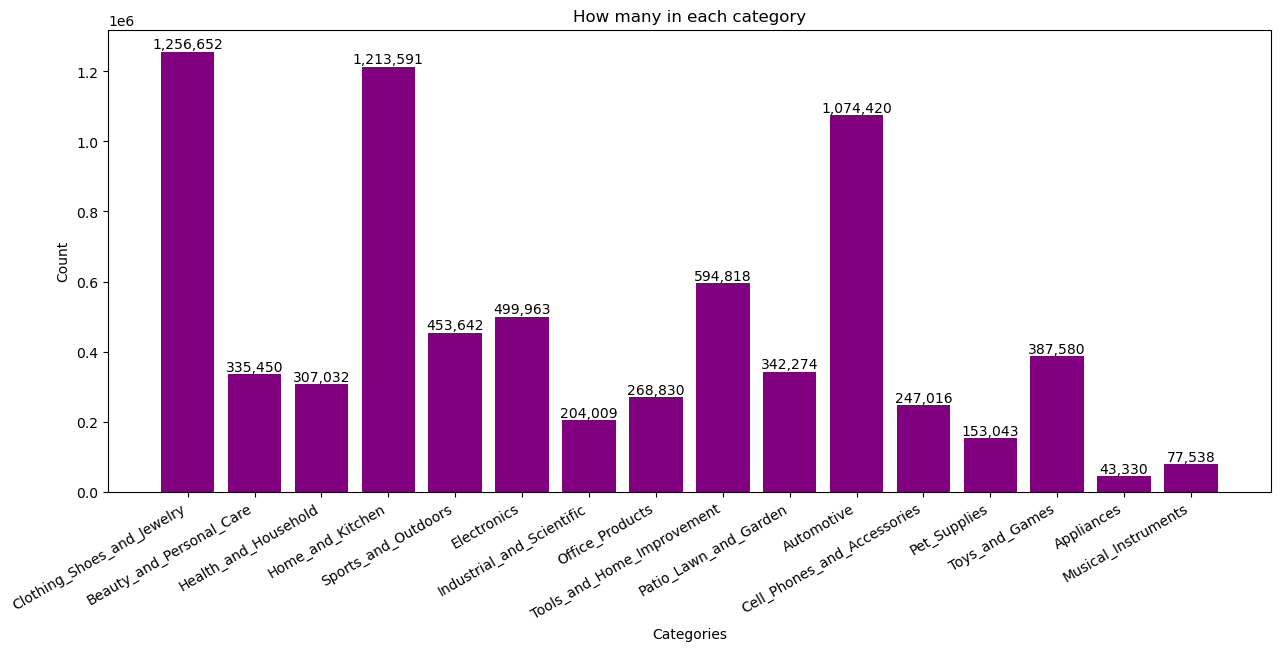

In [17]:
from collections import Counter
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="purple")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [18]:
from collections import defaultdict
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

print(f"\nMinimum: {min([len(slot) for slot in slots.values()]):,}")


Minimum: 16


In [19]:
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=400:
        sample.extend(slot)
    elif len(slot) <= 900:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=900, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)
len(sample)

421311

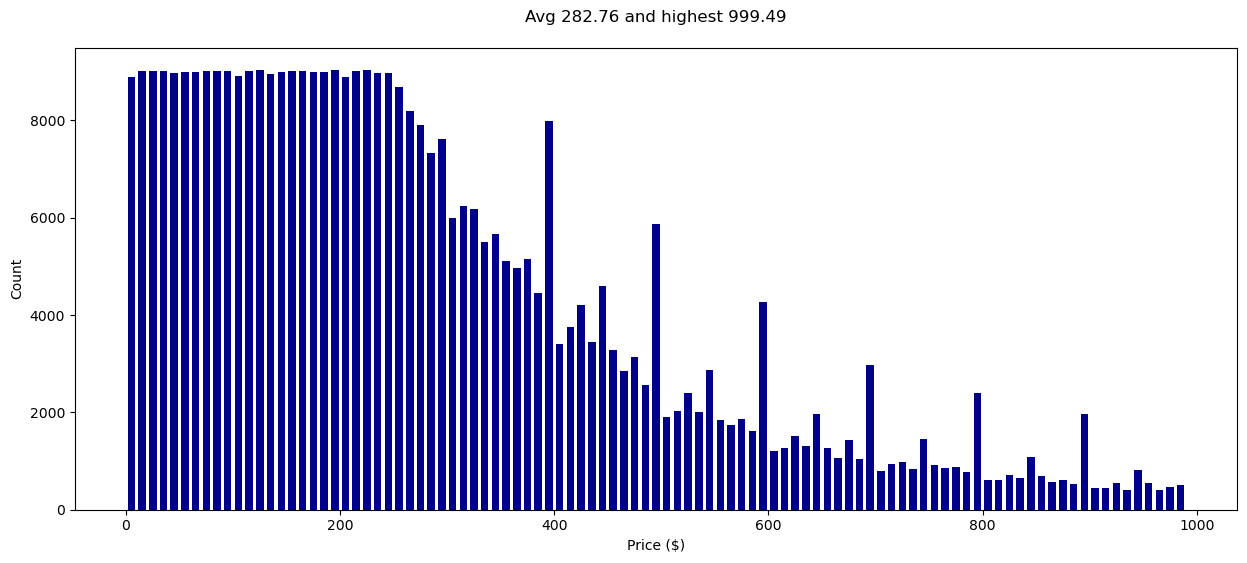

In [20]:
# Plot the distribution of prices

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

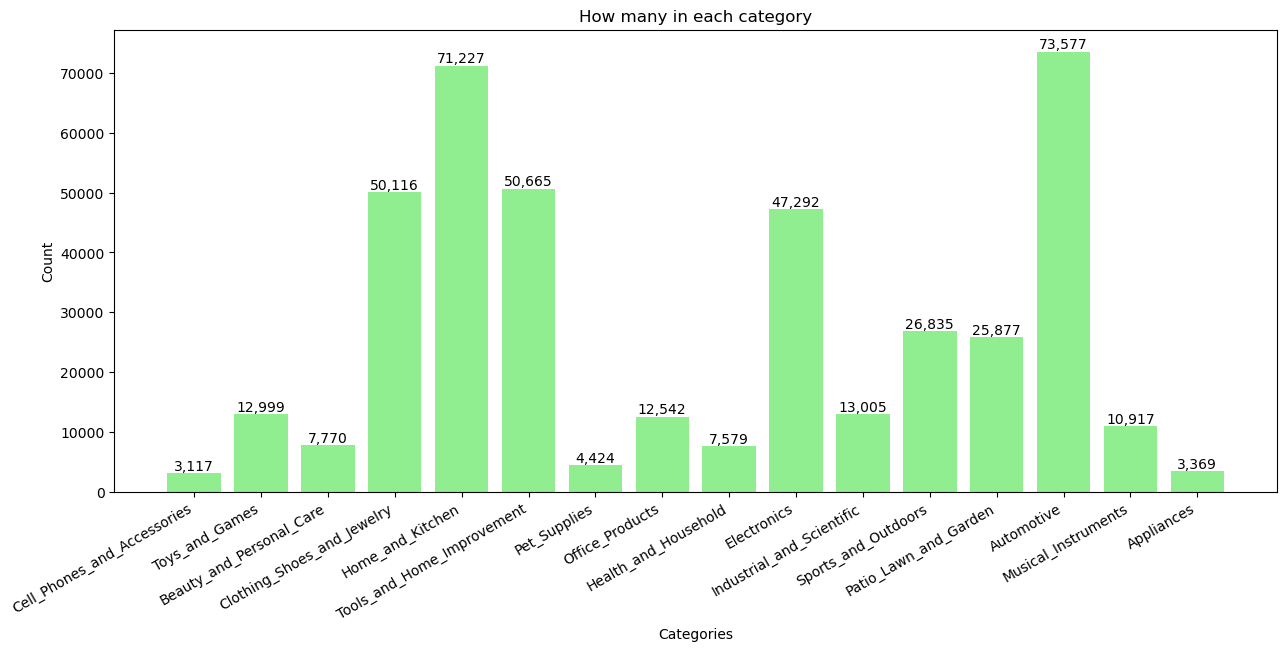

In [21]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [22]:
report(sample[400000])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You estimate prices to the nearest dollar<|eot_id|><|start_header_id|>user<|end_header_id|>

How much is this?
Inspired Home Monroe Blush Velvet Platform Bed Queen Size Our velvet bed frame adds a measure of modern sophistication and elegance to your bedroom. Get the feeling of laying your head down each night in a upscale five star hotel room. This stylish bed frame features exquisite velvet, a button tufted high density foam padded headboard, and tapered solid wood legs to provide a luxurious end to your day. SPECIFICATIONS DIMENSIONS 66.2 W x 87.8 D x 59.9 H DIMENSIONS 66.2 W x 87.8 D x 59.9 H FABRIC and MATERIALS Velvet, Foam, Plywood, Eucalyptus FABRIC and<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Price is $740.00<|eot_id|>
[78191, 128007, 271, 7117, 374, 400, 21112, 13, 410, 128009]
['assistant', '<|end_header_id|>', '\n\n', 'Price', ' is', ' $', '740', '.', '00', '<|eot_id|>']


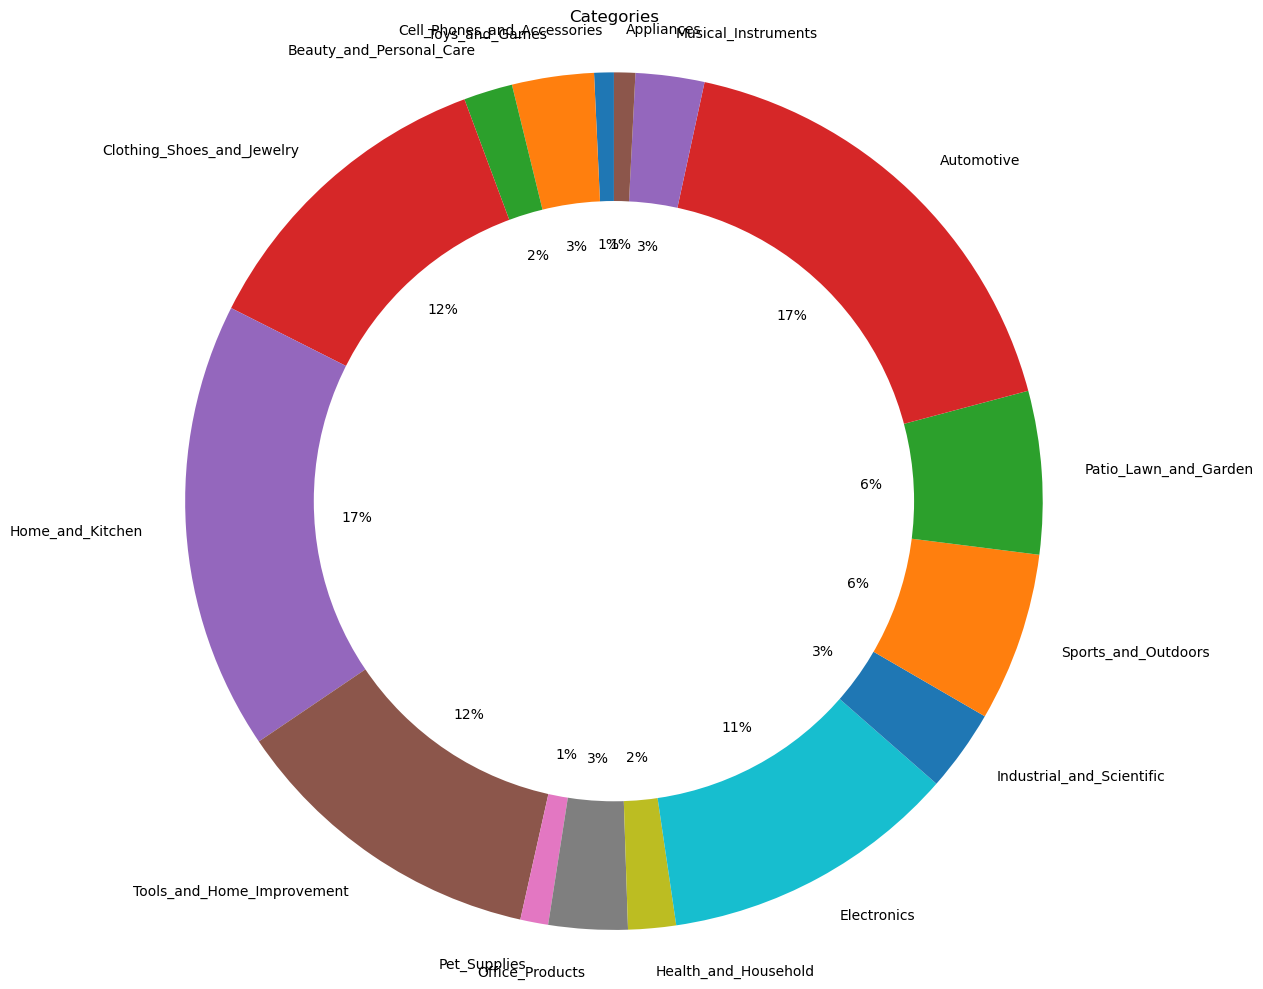

In [23]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Customize the chart
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Display the chart
plt.tight_layout()
plt.show()

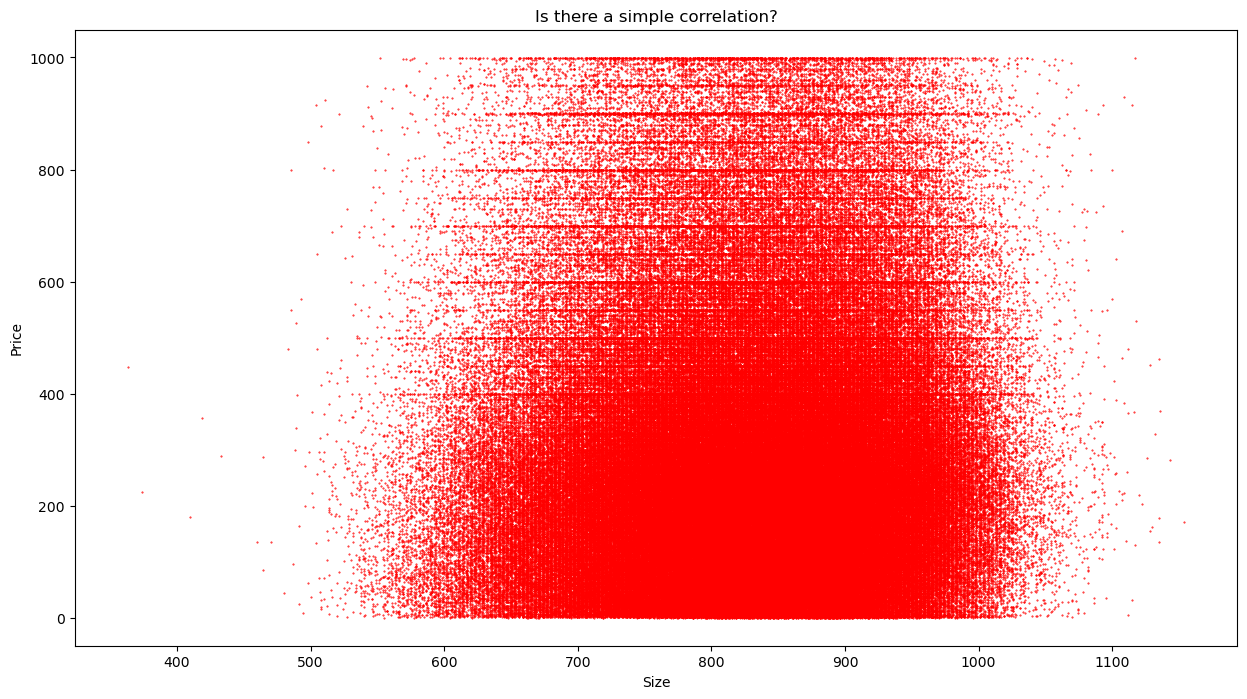

In [24]:
sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

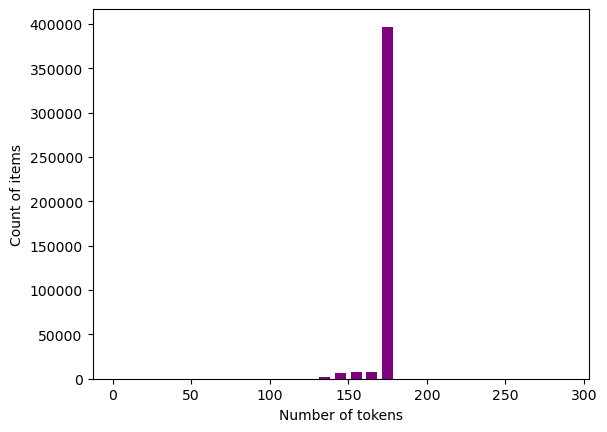

In [25]:
# Plot the distribution again to check it looks as expected

token_counts = [item.token_count for item in sample]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of items');
_ = ax.hist(token_counts, rwidth=0.7, color="purple", bins=range(0, 300, 10))

In [26]:
report(sample[-2])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You estimate prices to the nearest dollar<|eot_id|><|start_header_id|>user<|end_header_id|>

How much is this?
RCF Art 915A 15-inch Active Speaker Power and Portability All in One Brand RCF, Model Name ART 915A, Speaker Type Subwoofer, Subwoofer Diameter 15 Inches, Mounting Type Wall Mount, Surround Sound Channel Configuration 2.0, Speaker Maximum Output Power 2100 Watts, Weight 58.8 pounds, Is Waterproof FALSE, Speaker Size 15 Inches, Power Source Corded Electric, Vehicle Service Type Car, Dimensions 30 x 18.7 x 18.5 inches, model number ART-915A, Rank Musical Instruments 22180, Powered Speaker Cabinets 44, Available August 26, 2021, Manufacturer R<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Price is $999.00<|eot_id|>
[78191, 128007, 271, 7117, 374, 400, 5500, 13, 410, 128009]
['assistant', '<|end_header_id|>', '\n\n', 'Price', ' is', ' $', '999', '.', '00', '<|eot_id|>']


In [27]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
validate = sample[400_000:410_000]
test = sample[410_000:420_000]
print(f"Divided into a training set of {len(train):,} items and validation set of {len(validate):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and validation set of 10,000 items and test set of 10,000 items


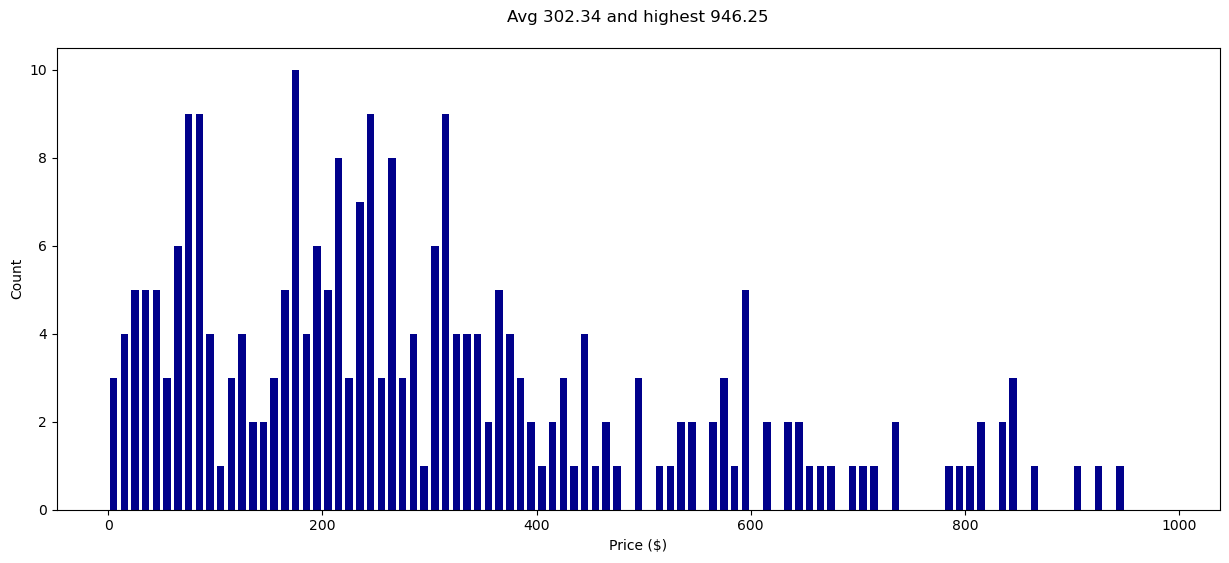

In [28]:
# Plot the distribution of prices

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [29]:
del items, slots
import gc
gc.collect()

37495

In [46]:
class PhiItem:
    phi_tokenizer = AutoTokenizer.from_pretrained(PHI3, trust_remote_code=True)
    
    def __init__(self, item):
        self.item = item
        self.prompt = self.phi_tokenizer.apply_chat_template(self.item.messages(), tokenize=False, add_generation_prompt=False)
        self.prompt = self.prompt.replace("How much is this?", "Estimate price to the nearest dollar:")
        self.token_count = len(self.phi_tokenizer.encode(self.prompt))
        
    def test_prompt():
        return self.prompt.split(self.item.PREFIX)[0] + self.item.PREFIX
        

In [47]:
item = PhiItem(train[0])

In [48]:
phis = [PhiItem(t) for t in tqdm(train)]

100%|█████████████████████████████████| 400000/400000 [01:30<00:00, 4434.87it/s]


In [49]:
max([phi.token_count for phi in phis])

352

In [60]:
smaller = [p for p in phis if p.token_count <= 220]

In [61]:
len(smaller)

353399

In [65]:
class GemmaItem:
    gemma_tokenizer = AutoTokenizer.from_pretrained(GEMMA, trust_remote_code=True)
    
    def __init__(self, item):
        self.item = item
        self.prompt = self.gemma_tokenizer.apply_chat_template(self.item.messages()[1:], tokenize=False, add_generation_prompt=False)
        self.prompt = self.prompt.replace("How much is this?", "Estimate price to the nearest dollar:")
        self.token_count = len(self.gemma_tokenizer.encode(self.prompt))
        
    def test_prompt():
        return self.prompt.split(self.item.PREFIX)[0] + self.item.PREFIX

In [66]:
item = GemmaItem(train[0])

In [69]:
gemmas = [GemmaItem(t) for t in tqdm(train)]

100%|█████████████████████████████████| 400000/400000 [01:45<00:00, 3794.27it/s]


In [70]:
smaller = [g for g in gemmas if g.token_count <= 180]

In [71]:
len(smaller)

288519

In [ ]:
import csv
with open('test.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:200]:
        writer.writerow([t.title, t.details, 0])

In [ ]:
human_predictions = []
with open('human.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[2]))

In [26]:
average = sum(t.price for t in train)/len(train)
average

282.68274244966665

In [30]:
class TestRunner:

    def __init__(self, predictor, data, title, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = RED if error>=20 else YELLOW if error>=10 else GREEN
        color_str = "red" if error>=20 else "yellow" if error>=10 else "green"
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color_str)
        print(f"{color}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = [e for e in self.errors if e<20]
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={len(hits)/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()
        return self

In [31]:
train_average = sum(t.price for t in train)/len(train)

def flat_predictor(item):
    return train_average

1: Guess: $282.68 Truth: $731.40 Error: $448.72 SLE: 0.90 Item: Bobkona Sectional Sofa Set Coffee
2: Guess: $282.68 Truth: $269.99 Error: $12.69 SLE: 0.00 Item: MAT EXPERT Kitchen Pantry Cupboard Cabin...
3: Guess: $282.68 Truth: $841.80 Error: $559.12 SLE: 1.19 Item: 2022 Flagship HP Pavilion 15.6" FHD 1080...
4: Guess: $282.68 Truth: $300.73 Error: $18.05 SLE: 0.00 Item: Five Ten Adidas Hiangle Pro Competition ...
5: Guess: $282.68 Truth: $80.95 Error: $201.73 SLE: 1.54 Item: WOG: New York 1776, the New York Campaig...
6: Guess: $282.68 Truth: $734.43 Error: $451.75 SLE: 0.91 Item: P3 POMPEII3 1 1/10ct Diamond Engagement ...
7: Guess: $282.68 Truth: $77.99 Error: $204.69 SLE: 1.63 Item: NOVICA Purple Hand Painted Alebrije Wood...
8: Guess: $282.68 Truth: $399.00 Error: $116.32 SLE: 0.12 Item: ddrum DD Beta XP Electronic Drum Kit
9: Guess: $282.68 Truth: $592.24 Error: $309.56 SLE: 0.54 Item: Lund Hard Tri-Fold Hard Folding Truck Be...
10: Guess: $282.68 Truth: $279.99 Error: $2.69 SL

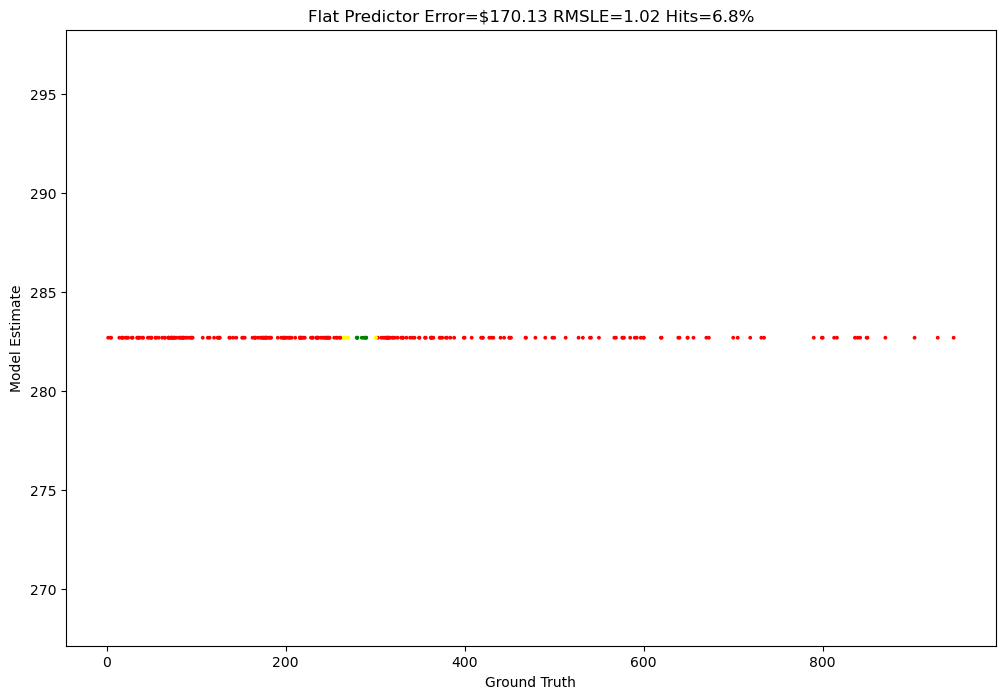

In [32]:
runner = TestRunner(flat_predictor, test, "Flat Predictor").run()

In [ ]:
human_predictions = []
with open('human.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[2]))

def human_predictor(item):
    index = test.index(item)
    if index==-1:
        raise ValueError("Index not found")
    return human_predictions[index]

In [ ]:
runner = TestRunner(human_predictor, test, "Human Predictor").run()

In [34]:
stop = set(['the', 'and', 'for', 'is', 'to', 'this', 'with', 'a', 'of', 'your', 'are', 'in','from', 'you', 'or', 'an', 'on', 'by'])

def words(item):
  text = f"{item.title} {item.details}"
  text = re.sub(r'[\(\)\[\]\{\},\'"\- \s]+', ' ', text)
  words = text.strip().lower().split(' ')
  filtered = [word for word in words if word not in stop]
  return " ".join(filtered)

In [35]:
documents = [words(item) for item in train]
from collections import Counter
count = Counter()
for doc in documents:
    ws = doc.split(" ")
    for w in ws:
        count[w]+=1
count.most_common(30)

[(':', 6100091),
 ('x', 911812),
 ('item', 722963),
 ('manufacturer', 572602),
 ('number', 564180),
 ('dimensions', 400697),
 ('type', 378885),
 ('inches', 361615),
 ('model', 353956),
 ('brand', 340658),
 ('weight', 339388),
 ('date', 338450),
 ('available', 334864),
 ('first', 333825),
 ('product', 319815),
 ('pounds', 306306),
 ('no', 270824),
 ('best', 270314),
 ('&', 268920),
 ('sellers', 268708),
 ('rank', 268288),
 ('material', 263723),
 ('1', 253801),
 ('color', 219483),
 ('part', 184983),
 ('size', 151616),
 ('batteries', 151329),
 ('package', 147824),
 ('discontinued', 147499),
 ('style', 132435)]

In [124]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np

np.random.seed(42)

labels = np.array([float(item.price) for item in train])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

regressor = LinearRegression()
regressor.fit(X, labels)

LinearRegression()

In [125]:
def linear_regression_predictor(item):
    np.random.seed(42)
    x = vectorizer.transform([words(item)])
    return max(regressor.predict(x)[0], 0)

1: Guess: $884.04 Truth: $731.40 Error: $152.64 SLE: 0.04 Item: Bobkona Sectional Sofa Set Coffee
2: Guess: $77.64 Truth: $269.99 Error: $192.35 SLE: 1.53 Item: MAT EXPERT Kitchen Pantry Cupboard Cabin...
3: Guess: $828.49 Truth: $841.80 Error: $13.31 SLE: 0.00 Item: 2022 Flagship HP Pavilion 15.6" FHD 1080...
4: Guess: $202.25 Truth: $300.73 Error: $98.48 SLE: 0.16 Item: Five Ten Adidas Hiangle Pro Competition ...
5: Guess: $0.00 Truth: $80.95 Error: $80.95 SLE: 19.41 Item: WOG: New York 1776, the New York Campaig...
6: Guess: $542.37 Truth: $734.43 Error: $192.06 SLE: 0.09 Item: P3 POMPEII3 1 1/10ct Diamond Engagement ...
7: Guess: $1.88 Truth: $77.99 Error: $76.11 SLE: 10.96 Item: NOVICA Purple Hand Painted Alebrije Wood...
8: Guess: $196.81 Truth: $399.00 Error: $202.19 SLE: 0.50 Item: ddrum DD Beta XP Electronic Drum Kit
9: Guess: $448.03 Truth: $592.24 Error: $144.21 SLE: 0.08 Item: Lund Hard Tri-Fold Hard Folding Truck Be...
10: Guess: $0.00 Truth: $279.99 Error: $279.99 SLE: 31

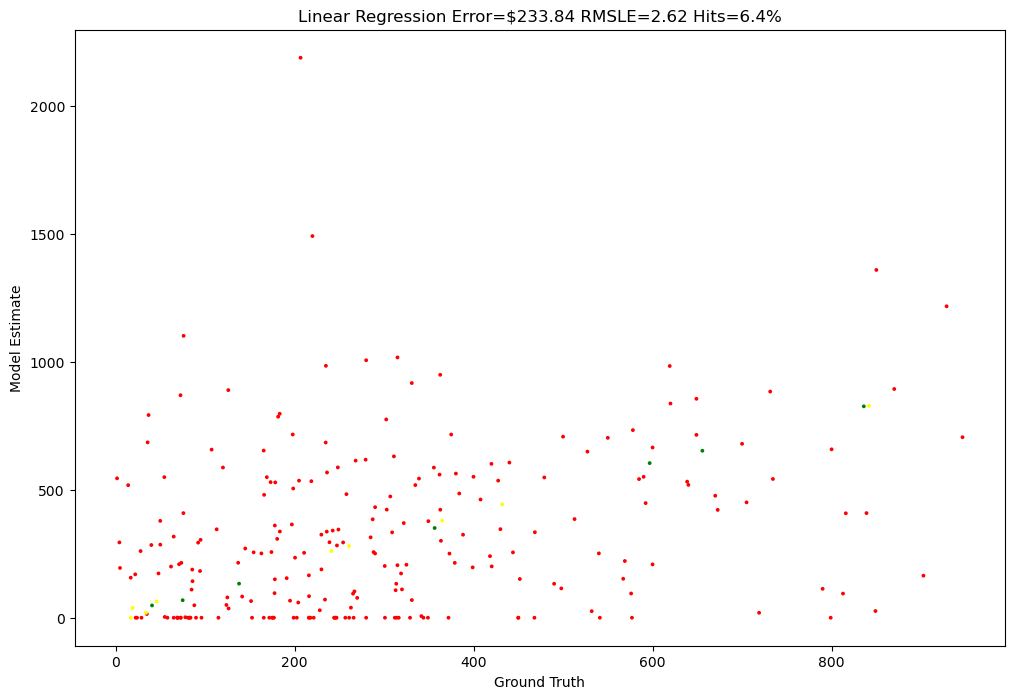

In [126]:
runner1 = TestRunner(linear_regression_predictor, test, "Linear Regression").run()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR

np.random.seed(42)

labels = np.array([float(item.price) for item in train])

vectorizer = TfidfVectorizer(max_features=20)
X = vectorizer.fit_transform(documents)

regressor = SVR(kernel='linear')
regressor.fit(X, labels)

In [49]:
def svr_predictor(item):
    np.random.seed(42)
    x = vectorizer.transform([words(item)])
    return max(regressor.predict(x)[0], 0)

1: Guess: $206.74 Truth: $731.40 Error: $524.66 SLE: 1.59 Item: Bobkona Sectional Sofa Set Coffee
2: Guess: $213.31 Truth: $269.99 Error: $56.68 SLE: 0.06 Item: MAT EXPERT Kitchen Pantry Cupboard Cabin...
3: Guess: $323.53 Truth: $841.80 Error: $518.27 SLE: 0.91 Item: 2022 Flagship HP Pavilion 15.6" FHD 1080...
4: Guess: $236.38 Truth: $300.73 Error: $64.35 SLE: 0.06 Item: Five Ten Adidas Hiangle Pro Competition ...
5: Guess: $187.86 Truth: $80.95 Error: $106.91 SLE: 0.70 Item: WOG: New York 1776, the New York Campaig...
6: Guess: $127.10 Truth: $734.43 Error: $607.33 SLE: 3.05 Item: P3 POMPEII3 1 1/10ct Diamond Engagement ...
7: Guess: $203.43 Truth: $77.99 Error: $125.44 SLE: 0.90 Item: NOVICA Purple Hand Painted Alebrije Wood...
8: Guess: $190.88 Truth: $399.00 Error: $208.12 SLE: 0.54 Item: ddrum DD Beta XP Electronic Drum Kit
9: Guess: $257.89 Truth: $592.24 Error: $334.35 SLE: 0.69 Item: Lund Hard Tri-Fold Hard Folding Truck Be...
10: Guess: $271.34 Truth: $279.99 Error: $8.65 SL

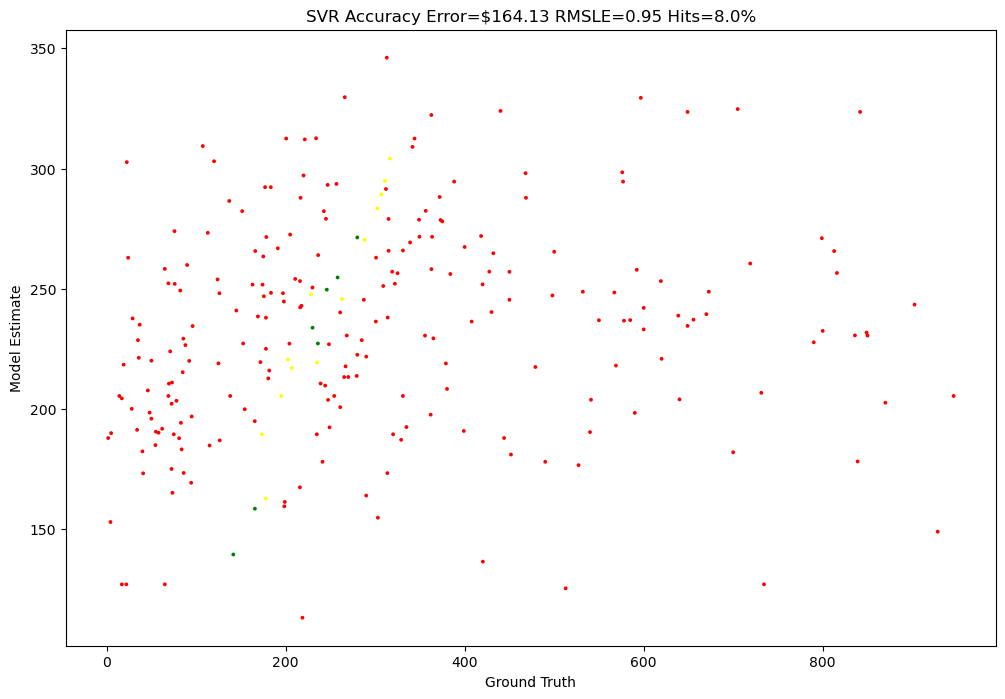

In [50]:
runner2 = TestRunner(svr_predictor, test, "SVR Accuracy").run()

In [109]:
def messages_for(item):
    system_message = "You estimate prices of items under $1000. Reply only with the price, no explanation"
    user_prompt = item.question()
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt}
    ]

In [110]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [111]:
def gpt_predictor(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", #OPENAI_MODEL,
        messages=messages_for(item),
        seed=42,
        max_tokens=6
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $699.00 Truth: $731.40 Error: $32.40 SLE: 0.00 Item: Bobkona Sectional Sofa Set Coffee
2: Guess: $250.00 Truth: $269.99 Error: $19.99 SLE: 0.01 Item: MAT EXPERT Kitchen Pantry Cupboard Cabin...
3: Guess: $800.00 Truth: $841.80 Error: $41.80 SLE: 0.00 Item: 2022 Flagship HP Pavilion 15.6" FHD 1080...
4: Guess: $200.00 Truth: $300.73 Error: $100.73 SLE: 0.17 Item: Five Ten Adidas Hiangle Pro Competition ...
5: Guess: $85.00 Truth: $80.95 Error: $4.05 SLE: 0.00 Item: WOG: New York 1776, the New York Campaig...
6: Guess: $850.00 Truth: $734.43 Error: $115.57 SLE: 0.02 Item: P3 POMPEII3 1 1/10ct Diamond Engagement ...
7: Guess: $65.00 Truth: $77.99 Error: $12.99 SLE: 0.03 Item: NOVICA Purple Hand Painted Alebrije Wood...
8: Guess: $499.00 Truth: $399.00 Error: $100.00 SLE: 0.05 Item: ddrum DD Beta XP Electronic Drum Kit
9: Guess: $800.00 Truth: $592.24 Error: $207.76 SLE: 0.09 Item: Lund Hard Tri-Fold Hard Folding Truck Be...
10: Guess: $299.00 Truth: $279.99 Error: $19.01 SLE: 0.

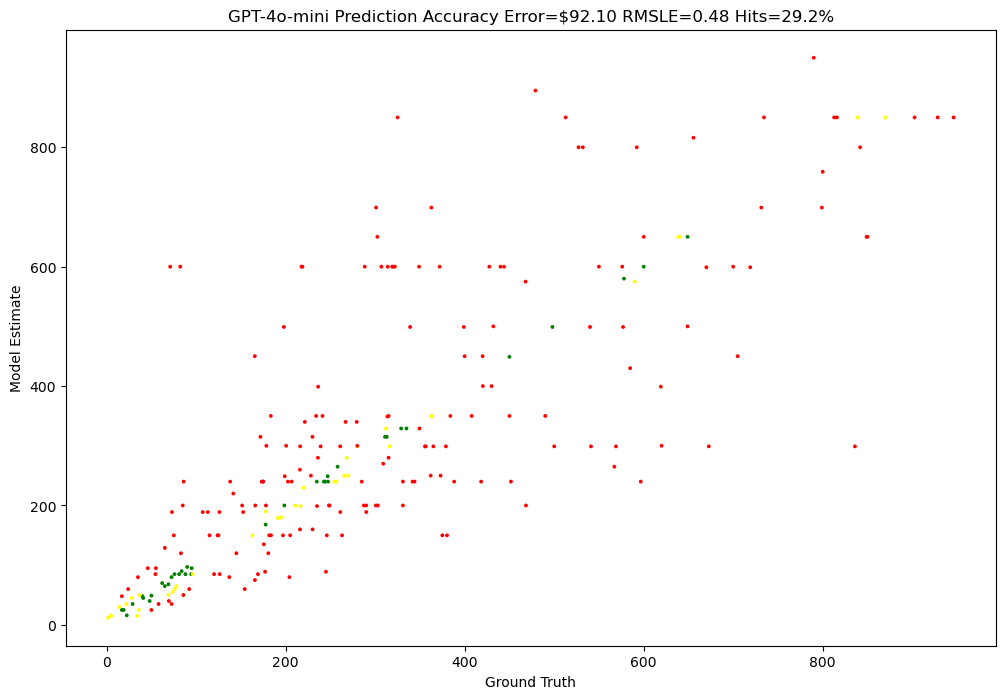

In [112]:
runner = TestRunner(gpt_predictor, test, "GPT-4o-mini Prediction Accuracy").run()

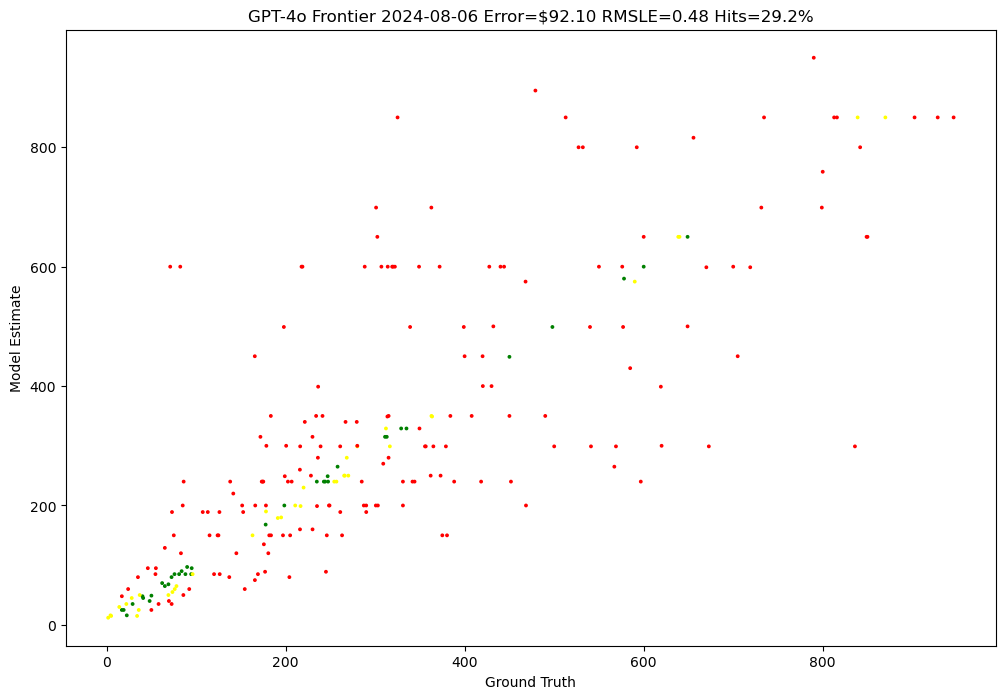

In [113]:
runner.title = "GPT-4o Frontier 2024-08-06"
runner.report()

In [ ]:
report(train[1])

In [114]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [116]:
train_prompts[1]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou estimate prices to the nearest dollar<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow much is this?\nEast West Furniture ESPO3-OAK-W Eden 3 Piece Room Furniture Set Contains a Round Kitchen Table with Pedestal and 2 Dining Chairs, 30x30 Inch, Oak EAST WEST FURNITURE - ESPO3-OAK-W - 3-PC DINETTE SET This dinette set includes 2 wooden dining room chairs and 1 Round table. This dining room table has a Round table top and Pedestal Legs. The solid wood frame and back ensure that these mid century wooden chairs sturdiness and offers decent support to your back, in addition to their ideal size these Urban Style chairs are trouble free to assemble and easy to rearrange. These simple but charming<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nPrice is $277.00<|eot_id|>'

In [117]:
# Create a Dataset from the lists
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [119]:
DATASET_NAME = "ed-donner/pricer-dataset"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ed-donner/pricer-dataset/commit/b040a07650013a11ae2533566643d094d6711841', commit_message='Upload dataset', commit_description='', oid='b040a07650013a11ae2533566643d094d6711841', pr_url=None, pr_revision=None, pr_num=None)